# PCA

PCA is a technique to emphasise variation and bring out strong patterns in a data set. It converts a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. It is a widely used method for dimensionality reduction.

PCA takes a data set and determines its co-variance matrix after performing mean normalisation on it. The Eigen vectors and Eigen values of the co-variance matrix are computed (giving us the EVS) and then the Eigen vectors are sorted in the descending order of Eigen values. This sorting step is the actual revelation of the PCA algorithm. The Eigen vectors have been sorted in the decreasing order of the Eigen values because the Eigen vector with the highest Eigen value is the principal component of the data set. That vector shows along which direction the majority of the data is inclined. Thus by PCA, we have been able to extract the lines that characterise the data

# Library

In [110]:
import cv2
import cv2 as cv
import numpy as np
from skimage import color
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
from matplotlib.pyplot import imread,imsave
from PIL import Image as im
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

we take non-overlapping blocks of size 5 x 5 from the difference image and flatten them into row vectors. The image can be resized to make both the dimensions a multiple of 5 by scipy.misc.imresize(). Collection of these row vectors forms a vector set.

# calculate vector set

In [2]:
def find_vector_set(diff_image, new_size):
    i = 0
    j = 0
    vector_set = np.zeros((int(new_size[0] * new_size[1] / 25), 25))

    print('\nvector_set shape',vector_set.shape)
    
    while i < vector_set.shape[0]:
        while j < new_size[0]:
            k = 0
            while k < new_size[1]:
                block   = diff_image[j:j+5, k:k+5]
                feature = block.ravel()
                vector_set[i, :] = feature
                k = k + 5
            j = j + 5
        i = i + 1
        
    mean_vec   = np.mean(vector_set, axis = 0)    
    vector_set = vector_set - mean_vec
    
    return vector_set, mean_vec

# Building the feature vector space

Building the FVS involves again taking 5 x 5 blocks from the difference image, flattening them, and lastly projecting them onto the EVS, only this time, the blocks will be overlapping.

A vector space (VS) is first made by constructing one vector for each pixel of the difference image such a way that one 5 x 5 block is actually a pixel’s 5 x 5 neighborhood.

4 boundary rows and 4 boundary columns pixels won’t get any feature vectors since they won’t have a 5 x 5 neighborhood. (We can manage with this exclusion of these pixels, since it is safe to assume here that any changes occurring would be concentrated in the middle regions of the images, rather than the edges).

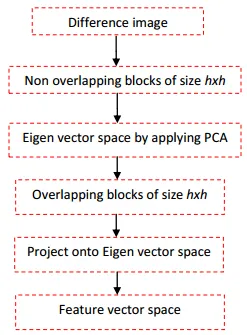

In [3]:
def find_FVS(EVS, diff_image, mean_vec, new):
    
    i = 2 
    feature_vector_set = []
    
    while i < new[0] - 2:
        j = 2
        while j < new[1] - 2:
            block = diff_image[i-2:i+3, j-2:j+3]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j+1
        i = i+1
        
    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec
    print("\nfeature vector space size",FVS.shape)
    return FVS

# Clustering (K-mean)

In [4]:
def clustering(FVS, components, new):
    
    kmeans = KMeans(components, verbose = 0)
    kmeans.fit(FVS)
    output = kmeans.predict(FVS)
    count  = Counter(output)

    least_index = min(count, key = count.get)            
    print(new[0],new[1])
    change_map  = np.reshape(output,(new[0] - 4, new[1] - 4))
    
    return least_index, change_map

# main program (PCA)

In [95]:
def find_PCAKmeans(imagepath1, imagepath2, combine=False):
    
    print('Operating')
    
    image1 = cv.imread(imagepath1)
    image2 = cv.imread(imagepath2)
    print(image1.shape,image2.shape) 
    if (combine==True):
        no_img = 3
        image1 = image1[:,:,0]/no_img + image1[:,:,1]/no_img + image1[:,:,2]/no_img
        image2 = image2[:,:,0]/no_img + image2[:,:,1]/no_img + image2[:,:,2]/no_img
    
    print(image1.shape,image2.shape) 
    new_size = np.asarray(image1.shape) / 5
    new_size = new_size.astype(int) * 5

    image1 = cv2.resize(image1, dsize=(new_size[1],new_size[0])).astype(np.int16)
    image2 = cv2.resize(image2, dsize=(new_size[1],new_size[0])).astype(np.int16)
    
    print(image1.shape,image2.shape) 
    diff_image = abs(image1 - image2)   
    print(diff_image.shape)
    cv.imwrite('diff.jpg', diff_image)
    print('\nBoth images resized to ',new_size)
        
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    
    pca     = PCA()
    pca.fit(vector_set)
    EVS = pca.components_
        
    FVS     = find_FVS(EVS, diff_image, mean_vec, new_size)
    print('\ncomputing k means')
    
    components = 3
    least_index, change_map = clustering(FVS, components, new_size)
    
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
    
    change_map = change_map.astype(np.uint8)
    print("change_map shape")
    print(change_map.shape)
    kernel     = np.asarray(((0,0,1,0,0),
                             (0,1,1,1,0),
                             (1,1,1,1,1),
                             (0,1,1,1,0),
                             (0,0,1,0,0)), dtype=np.uint8)
    cleanChangeMap = cv2.erode(change_map,kernel)
    cv.imwrite("changemap.jpg", change_map)
    cv.imwrite("cleanchangemap.jpg", cleanChangeMap)
    return(cleanChangeMap)

# Run the program

In [117]:
# a1 = 'corpus\AyakkumLake\AyakkumLake_09212003.jpg'
# b1 = 'corpus\AyakkumLake\AyakkumLake_09132012.jpg'
a1 = 'corpus\Dubai\Dubai_11122012.jpg'
b1 = 'corpus\Dubai\Dubai_11272000.jpg'
# a1 = 'corpus/ACD/2_im1.bmp'
# b1 = 'corpus/ACD/2_im2.bmp'
cleanChangeMap = find_PCAKmeans(b1,a1,combine=True)   

Operating
(1600, 1600, 3) (1600, 1600, 3)
(1600, 1600) (1600, 1600)
(1600, 1600) (1600, 1600)
(1600, 1600)

Both images resized to  [1600 1600]

vector_set shape (102400, 25)

feature vector space size (2547216, 25)

computing k means
1600 1600
change_map
(1596, 1596)


# Compare the result

In [118]:
def biner_image(col_true,col_false,img_gt):
    # Threshold image to binary
    img_gt = color.rgb2gray(img_gt)
    thresh = threshold_otsu(img_gt)
    img_gt = img_gt > thresh

    # Make 3 channel RGB image same dimensions
    gt = np.zeros((img_gt.shape[0],img_gt.shape[1],3), dtype=np.uint8)

    # Make True pixels red
    gt[img_gt]  = col_true
    # Make False pixels blue
    gt[~img_gt] = col_false
    return(gt)

In [119]:
def plot_result(img_2,result):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 15),
                          sharex=True, sharey=True,frameon=False)
    axes.set_axis_off()
    plt.imshow(img_2)
    plt.imshow(result,alpha=0.5)
#     plt.imshow(gt,alpha=0.5)
    plt.show()

C:\Users\imanursar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  This is separate from the ipykernel package so we can avoid doing imports until


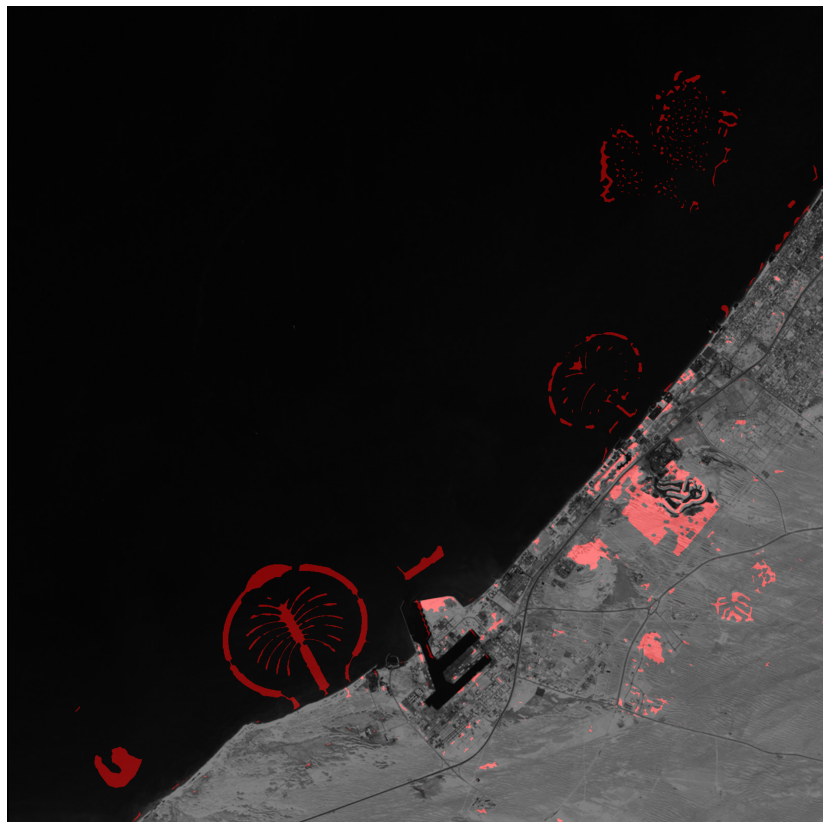

In [120]:
# gt = biner_image([0,255,0],[0,0,0],img_gt)
b1 = cv.imread('corpus\Dubai\Dubai_11272000.jpg')
re = biner_image([255,0,0],[0,0,0],cleanChangeMap)
plot_result(b1,re)